In [4]:
# Testing Notebook

In [5]:
from mmengine.registry import init_default_scope
init_default_scope('mmselfsup')

from MCA.models import WideModel, WideModelClassifier
from MCA.utils import load_checkpoint
from MCA.inference import run_on_dataloader

import pandas as pd
import numpy as np

In [6]:
checkpoint_dict = load_checkpoint(
    '/home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/src/MCA/z_RUNS',
    get_dataset=True,
    dataloader_kwargs={'batch_size':64, 'num_workers':8})
model = checkpoint_dict['model']

Loading: /home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/src/MCA/z_RUNS/iter_600.pth
Loading Model from /home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/src/MCA/z_RUNS/20260113_151400/vis_data/config.py
Model loaded successfully.
Device for computation: cuda
Dataset contains annotations
Dataset contains 145161 cells.


100%|██████████| 1/1 [00:00<00:00, 801.51it/s]

All Markers: ['PD-1' 'CD45RA' 'CCR6' 'GranzymeB' 'CD163' 'T-bet' 'CD4' 'EGFR' 'TCRb'
 'CD20' 'CD45RO' 'MMP-9' 'CD57' 'MUC-1' 'CD162' 'CD11b' 'CD25'
 'Cytokeritin' 'CD46' 'CD56' 'HLA-DR' 'TCR-g-d' 'CD5' 'CD8' 'CD30' 'BCL-2'
 'IDO-1' 'CD2' 'CD11c' 'b-Catenin' 'CD69' 'Collagen4' 'CD68' 'CD7' 'LAG-3'
 'DAPI-01' 'a-SMA' 'MCT' 'PD-L1' 'Vimentin' 'CD15' 'CD31' 'Tim-3' 'FoxP3'
 'CD16' 'Podoplanin' 'CD206' 'VISA' 'CD44']
Used Markers: ['PD-1' 'CD45RA' 'CCR6' 'GranzymeB' 'CD163' 'T-bet' 'CD4' 'EGFR' 'TCRb'
 'CD20' 'CD45RO' 'MMP-9' 'CD57' 'MUC-1' 'CD162' 'CD11b' 'CD25'
 'Cytokeritin' 'CD46' 'CD56' 'HLA-DR' 'TCR-g-d' 'CD5' 'CD8' 'CD30' 'BCL-2'
 'IDO-1' 'CD2' 'CD11c' 'b-Catenin' 'CD69' 'Collagen4' 'CD68' 'CD7' 'LAG-3'
 'DAPI-01' 'a-SMA' 'MCT' 'PD-L1' 'Vimentin' 'CD15' 'CD31' 'Tim-3' 'FoxP3'
 'CD16' 'Podoplanin' 'CD206' 'VISA' 'CD44']
101612 14516 29033
Using None split!


In [7]:
checkpoint_dict.keys()

dict_keys(['model', 'dataset', 'dataloader', 'config'])

In [8]:
ret = run_on_dataloader(checkpoint_dict['dataloader'], checkpoint_dict['model'], checkpoint_dict['dataset'], run_n=40000)
df = pd.DataFrame(ret)

 28%|██▊       | 625/2269 [00:50<02:11, 12.47it/s]


/home/simon_g/anaconda3/envs/MIDL26/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


['B' 'CD4' 'DC' 'CD8' 'M2' 'Monocyte' 'Endothelial' 'Mast' 'Tumor' 'Other'
 'TReg' 'M1' 'NK' 'Epithelial' 'Neutrophil' 'Cytotoxic CD8' 'Seg Artifact'
 'Lymphatic']


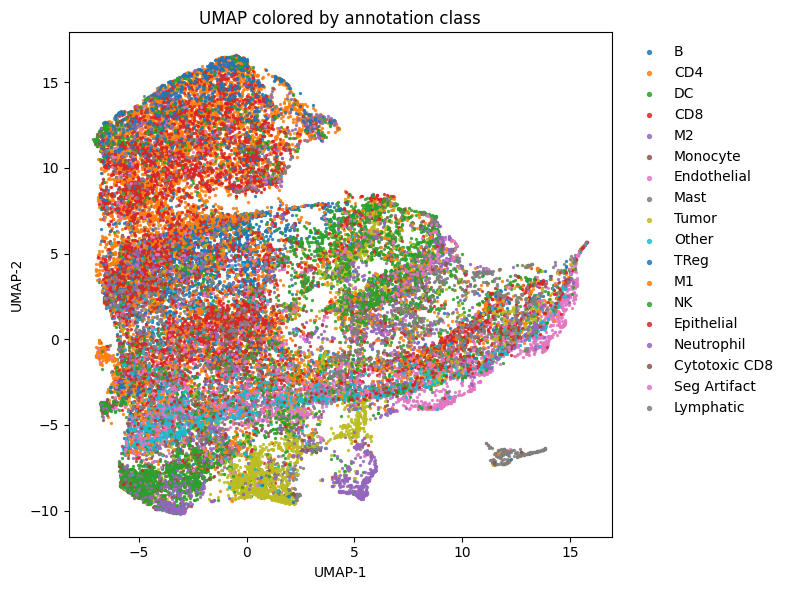

In [9]:
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt

# ---- 1) Build features matrix (n_samples, n_features) robustly ----
# df["features"] can be lists, np arrays, or torch tensors
feat_list = df["features"].tolist()

def _to_1d_numpy(v):
    # torch tensor -> numpy, list -> numpy, numpy -> itself
    try:
        import torch
        if isinstance(v, torch.Tensor):
            v = v.detach().cpu().numpy()
    except Exception:
        pass
    v = np.asarray(v)
    return v.ravel()

X = np.vstack([_to_1d_numpy(v) for v in feat_list]).astype(np.float32)

# ---- 2) Run UMAP ----
reducer = umap.UMAP(
    n_components=2,
    metric="euclidean",
    random_state=42,
    n_neighbors=10,
    min_dist=0.05,
    spread=2,
)
emb = reducer.fit_transform(X)  # shape (n_samples, 2)

df['UMAP_X'] = emb[:,0]
df['UMAP_Y'] = emb[:,1]

# ---- 4) Plot colored by class ----
classes = df["annotations"].unique()
print(classes)

plt.figure(figsize=(8, 6))
for c in classes:
    m = df["annotations"].values == c
    plt.scatter(
        df.loc[m, "UMAP_X"],
        df.loc[m, "UMAP_Y"],
        s=2,
        alpha=0.8,
        label=c,
    )

plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.title("UMAP colored by annotation class")
plt.legend(markerscale=2, bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)
plt.tight_layout()
plt.show()